In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
from data import read_data
from utils import data_preprocess,generate_features
from sklearn.preprocessing import StandardScaler,MinMaxScaler

df = read_data()
scaler = StandardScaler()
sca_x = scaler.fit_transform(df.iloc[:, :-1])
gru_reward=[]
reward_baseline =[]
lstm_reward=[]
x,y = generate_features(df,sca_x,max_len=20,pre_days = 10)
total_num = len(x)
train_num = int(total_num*0.7)
val_num = int(total_num*0.8)
x_train, y_train = x[:train_num], y[:train_num]
x_val, y_val = x[train_num:val_num], y[train_num:val_num]
x_test, y_test = x[val_num:], y[val_num:]
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.batch(batch_size).shuffle(10000)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(batch_size)

sample = next(iter(train_ds))
print('x_train.shape:', sample[0].shape)
print('y_train.shape:', sample[1].shape)

2739
x_train.shape: (64, 20, 5)
y_train.shape: (64,)


In [9]:
from network import LSTMModel,GRUModel
model = GRUModel()
model.compile(optimizer = keras.optimizers.Adam(0.001),
              loss = tf.keras.losses.MeanAbsoluteError(),
              metrics = tf.keras.losses.MSE)

epochs = 500
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/500
30/30 [==============================] - 2s 23ms/step - loss: 34.9999 - mean_squared_error: 1409.5520 - val_loss: 90.5458 - val_mean_squared_error: 8282.0713
Epoch 2/500
30/30 [==============================] - 0s 13ms/step - loss: 34.5332 - mean_squared_error: 1380.8258 - val_loss: 89.9277 - val_mean_squared_error: 8176.2388

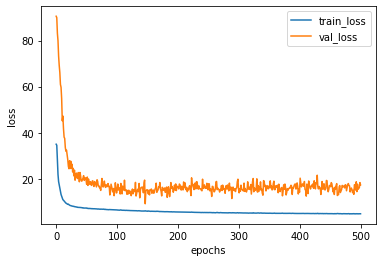

In [10]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_mse = history_dict['mean_squared_error']
val_mse = history_dict['mean_squared_error']

for i in range(len(train_loss)):
    train_loss[i] = train_loss[i]
    val_loss[i] = val_loss[i]

plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

                 Open      High        Low      Close       Volume
Date                                                              
2021-12-31  146.05000  146.6980  144.85200  144.85200   18135180.0
2021-12-30  146.69400  147.3000  145.99400  146.20000   15687720.0
2021-12-29  146.64400  147.4170  145.64700  146.65500   17787460.0
2021-12-28  148.23600  148.2990  146.05400  146.68700   18254300.0
2021-12-27  147.25600  148.3440  147.16900  147.90600   15984460.0
...               ...       ...        ...        ...          ...
2004-08-25    2.62400    2.7000    2.59700    2.65000  183956000.0
2004-08-24    2.78100    2.7900    2.58925    2.62175  305252000.0
2004-08-23    2.76875    2.8370    2.72625    2.73500  365488000.0
2004-08-20    2.52525    2.7270    2.51250    2.70775  457144000.0
2004-08-19    2.50000    2.6015    2.39900    2.50850  894076000.0

[4374 rows x 5 columns]
                 Open      High        Low      Close       Volume
Date                                 

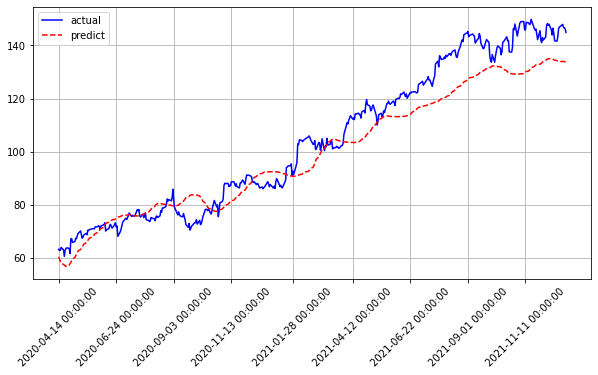

In [11]:
print(df.head())
model.summary()
model.evaluate(test_ds)
y_pred = model.predict(x_test)
df_time = df.index[-len(y_test):]
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(df_time, y_test, 'b-', label='actual')
axes.plot(df_time, y_pred, 'r--', label='predict')
axes.set_xticks(df_time[::50])
axes.set_xticklabels(df_time[::50], rotation=45)
plt.legend()
plt.grid()
plt.show()

14/14 [==============================] - 0s 5ms/step


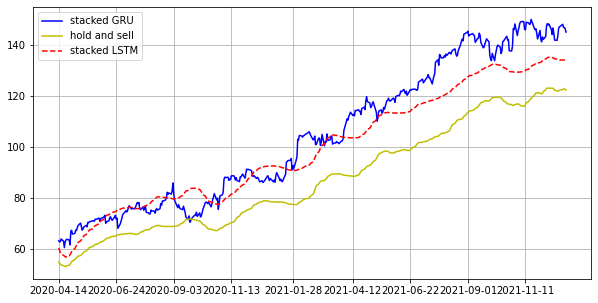

In [13]:
df_time = df.index[-len(y_test):]
fig = plt.figure(figsize=(10, 5))
axes = fig.add_subplot(111)
axes.plot(df_time, gru_reward, 'b-', label='stacked GRU')
axes.plot(df_time, reward_baseline 'y-', label='hold and sell')
axes.plot(df_time, lstm_reward), 'r--', label='stacked LSTM')
axes.set_xticks(df_time[::50])
plt.legend()
plt.grid()
plt.show()